<p style="text-align:center">
    <a href="https://www.ict.mahidol.ac.th/en/" target="_blank">
    <img src="https://www3.ict.mahidol.ac.th/ICTSurveysV2/Content/image/MUICT2.png" width="400" alt="Faculty of ICT">
    </a>
</p>

# Lab08: ML Basics: Classification


__Instructions:__
1. Append your ID at the end of this jupyter file name. For example, ```ITCS227_Lab0X_Assignment_6788123.ipynb```
2. Complete each task and question in the lab.
3. Once finished, raise your hand to call a TA.
4. The TA will check your work and give you an appropriate score.
5. Submit your IPYNB source code to MyCourses as record-keeping.

## Library of Helper Functions

In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve
import warnings
from sklearn.exceptions import FitFailedWarning

def _show_classification_report(model, y_true, y_pred, target_names):
    '''
        Function to print performance metrics
    '''
    accuracy = accuracy_score(y_true, y_pred)
    sensitivity = recall_score(y_true, y_pred, pos_label=1, average='weighted')
    specificity = recall_score(y_true, y_pred, pos_label=0, average='weighted')
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Sensitivity: {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print("Classification Report:")
    class_report = classification_report(y_true, y_pred, target_names=target_names)
    print(class_report)
    res = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
    return pd.json_normalize(res, sep='_')
    
def _show_confusion_matrix(model, y_true, y_pred, target_names):
    '''
        Function to plot confusion matrix
    '''
    cm = confusion_matrix(y_true, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=target_names)
    disp.plot(cmap=plt.cm.Blues,)
    plt.gcf().set_size_inches(3.5, 3.5)
    disp.ax_.set_title(f'Confusion Matrix for {model.__class__.__name__}', fontsize=8)
    plt.show()
    
def _plot_histogram_of_frequencies(data, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(7,2.5))
    unique_values, counts = np.unique(data, return_counts=True)
    barh = plt.bar(unique_values, counts)
    plt.xlabel("Values")
    plt.ylabel("Frequency")
    plt.title("Histogram")
    plt.xticks(unique_values)
    ax.bar_label(barh, fmt='%.2f')
    ax.set_ylim(bottom=0, top=1.25*max(counts))
    print('Class Split:', counts/sum(counts))
    plt.show()
    
def _make_learning_curve(model, X_train, y_train, scoring="f1_weighted", num_training_sizes=10):
    def _plot_learning_curve(model, train_sizes, train_scores, valid_scores, metric='F1 Score', plt_text='', ax=None):
        if not ax:
            fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3), sharey=True, sharex=True)
        train_errors = train_scores.mean(axis=1)
        valid_errors = valid_scores.mean(axis=1)
        ax.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
        ax.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
        ax.set_xlabel("Training set size")
        ax.set_ylabel(f'{metric}')
        # plt.gca().set_xscale("log", nonpositive='clip')
        ax.grid()
        ax.legend(loc="upper right")
        ax.set_ylim(bottom=0, top=1.25*max([1]))
        ax.set_title(f'{model.__class__.__name__}\n{plt_text}', fontsize=8)
        plt.show()
        
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FitFailedWarning)
        train_sizes, train_scores, valid_scores = learning_curve( model, 
                                                    X_train, y_train, 
                                                    train_sizes=np.linspace(0.01, 1.0, num_training_sizes), # e.g. `num` size intervals, from 1% to 100%
                                                    cv=5,     # CV=5 means  Train = 80%  , Test = 20%.
                                                              # CV=10 means Train = 90%  , Test = 10%.
                                                              #   - The fit/predict is repeated 5 times with random samples taken from X/Y.
                                                              #   - The resulting error is the average across all 5 trials; so a smoother and fairer result than CV=1 , which is hold-out.
                                                    scoring=scoring,
                                                    n_jobs=-1
                                                )
    _plot_learning_curve(model, train_sizes, train_scores, valid_scores, metric=scoring.replace('_',' ').title(), plt_text='')


```




```

# Part 1 - Analysing the Breast Cancer Dataset

Fill in the code (find examples in Tutorial and in slides) and answer the questions according to the steps below:

**Steps:**

- **Step 0:** 	Define the Dataset and Objective:
    - Consider Actions:
        - `malignant` -> Send for Treatment (treatment)
        - `benign` -> Send Home (no treatment)
- **Step 1:** 	Identify which cell is most crucial.
- **Step 2:** 	Define Positive (P) and Negative (N)
    - Consider the two classes are:
        - `malignant` (P)
        - `benign` (N)
- **Step 3:** 	State True and False
-  …fit model,  evaluate model ,  count errors …
- **Step 4:** 	Calculate the metric
- **Step 5:** 	Decide if objective met.
    - Consider **Minimum Metric Score is 0.9 or 90%.**



## Q1: Identify which Class is most important:
(Either - `malignant` (P) or `benign` (N) )
* Ans: Malignant

## Q2: Identify which Error (FP or FN) is most important:

(Either (1)`FP and FN` or (2) `FP` or (3) `FN` is most important. Explain why in a sentence.)

* Ans: FN, because if patience actually need a treatment, it can cause a life if they didn't get it

## Q3: Which Metric is helps measure that condition?

* Ans: Recall/sensitivity

### Load the dataset

In [2]:
from sklearn import datasets
import pandas as pd
import numpy as np
data = datasets.load_breast_cancer()
# print('The dataset is ', data['DESCR'])

Target classes:  ['malignant', 'benign'] 	(Note: Typically, class 0 is "P" and class 1 is "N".)
Class Split: [0.37258348 0.62741652]


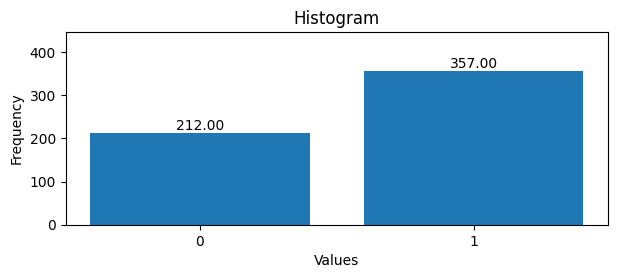

In [3]:
df = pd.DataFrame(data=np.c_[data['data'], data['target']],
                     columns=data['feature_names'].tolist() + ['target'])
target_names = data['target_names'].tolist()
print('Target classes: ', target_names, '\t(Note: Typically, class 0 is "P" and class 1 is "N".)')
_plot_histogram_of_frequencies(df['target'])


### Select `X` (input features) and `y` (target feature):
* Define your X and y data, from features in the `breast_cancer` dataset:

In [4]:
# insert your code here
display(df.count())

X = df.drop(columns=['target'])
y = df['target']

mean radius                569
mean texture               569
mean perimeter             569
mean area                  569
mean smoothness            569
mean compactness           569
mean concavity             569
mean concave points        569
mean symmetry              569
mean fractal dimension     569
radius error               569
texture error              569
perimeter error            569
area error                 569
smoothness error           569
compactness error          569
concavity error            569
concave points error       569
symmetry error             569
fractal dimension error    569
worst radius               569
worst texture              569
worst perimeter            569
worst area                 569
worst smoothness           569
worst compactness          569
worst concavity            569
worst concave points       569
worst symmetry             569
worst fractal dimension    569
target                     569
dtype: int64

<details><summary><span style="color:red">&#x1F6C8; Help</span> (Use this only as a last resort!!)</summary>

```Python
X = df.drop(columns=['target'])
y = df['target']
```

</details>


### Split as X and y:
* Split X / y into train and test sets.

In [5]:
# insert your code here
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

<details><summary><span style="color:red">&#x1F6C8; Help</span> (Use this only as a last resort!!)</summary>

```Python
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0) # Split into 85% training and 15% testing data
```

</details>

### Choose a model to fit() on the training data:
* Model Options:
    1. Previously we have imported and fitted a `LogisticRegression()` model.
    2. Read and choose a model from [Scikit-Learn's Classifer Comparison page](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html).
 
If you choose a K Nearest Neigbour algorithm, be sure to use StandardScaler on the X_train / X_test data.

* Choose a `model = ... ()` and `model.fit( ... )` on the training data.

In [6]:
# insert your code here
from sklearn.svm import SVC

model = SVC(kernel='linear')
model.fit(X, y)

SVC(kernel='linear')

<details><summary><span style="color:red">&#x1F6C8; Help</span> (Use this only as a last resort!!)</summary>

```Python
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# model = LogisticRegression()
# model = GradientBoostingClassifier()
# model = SVC(kernel='rbf')
# model = SVC(kernel='linear')
# model = GaussianNB()
# model = MultinomialNB()

# model.fit(X_traid, y_train)
# ... or ...


# model = KNeighborsClassifier(3)
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# model.fit(X_train_scaled, y_train)
```

</details>

### Plot a learning curve:

*  Plot the learning curve for your model, using the **Weighted F1 Score** (`scoring=f1_weighted`) metric.

> Note:
> - Using `F1 Score` means `we want a value closer to 1.0` *(In regression learning curves, we displayed `errors` where smaller values are preferred.)*
> - `Weighted F1 Score` assumes we want to learn a balanced classifier, you could easily change to another metric.

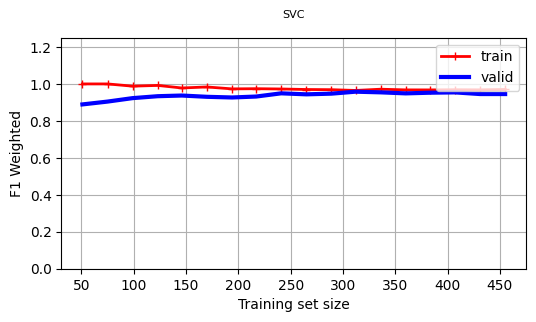

In [7]:
_make_learning_curve(model=model, X_train = X, y_train = y, scoring="f1_weighted", num_training_sizes=20)

<details><summary><span style="color:blue">&#x1F6C8; Hint</span></summary>

Find the Library of Helper Functions code at the top.
```Python
# _make_learning_curve( ... )
```

* This is the same function as we used in `Lab07`, before midterm on the regression models.
* This lets us check for `Overfitting, Underfitting` and `Generalized Fits` for our model. 
* If the code runs `very slowly`, read at the function (top of file) and reduce the arguments e.g. `cv=2` and `num_training_sizes=3`

</details>

## Q4: Is the model `Overfitting, Underfitting` or has a `Generalized Fit`?

Ans: It's look like Generalized

### Evaluate on the Test Set:
*  Collect prediction results (`y_pred`) on test data (`X_test`)

In [8]:
# insert your code here
y_pred = model.predict(X_test)
_show_classification_report(model=model,y_true=y_test,y_pred=y_pred,target_names=target_names)

Accuracy: 0.9649
Sensitivity: 0.9649
Specificity: 0.9649
Classification Report:
              precision    recall  f1-score   support

   malignant       0.94      0.98      0.96        47
      benign       0.98      0.96      0.97        67

    accuracy                           0.96       114
   macro avg       0.96      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114



c:\Users\gifly\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1618: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


,accuracy,malignant_precision,malignant_recall,malignant_f1-score,malignant_support,benign_precision,benign_recall,benign_f1-score,benign_support,macro avg_precision,macro avg_recall,macro avg_f1-score,macro avg_support,weighted avg_precision,weighted avg_recall,weighted avg_f1-score,weighted avg_support
0,0.964912,0.938776,0.978723,0.958333,47.0,0.984615,0.955224,0.969697,67.0,0.961695,0.966974,0.964015,114.0,0.965716,0.964912,0.965012,114.0


<details><summary><span style="color:blue">&#x1F6C8; Hint</span></summary>

```Python
... = model.predict(X_test)
```

</details>

* Print the Classification report using the `_show_classification_report( .. )` function from the top of file.

In [9]:
# insert your code here

_show_classification_report(model=model,y_true=y_test,y_pred=y_pred,target_names=target_names)

Accuracy: 0.9649
Sensitivity: 0.9649
Specificity: 0.9649
Classification Report:
              precision    recall  f1-score   support

   malignant       0.94      0.98      0.96        47
      benign       0.98      0.96      0.97        67

    accuracy                           0.96       114
   macro avg       0.96      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114



c:\Users\gifly\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1618: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


,accuracy,malignant_precision,malignant_recall,malignant_f1-score,malignant_support,benign_precision,benign_recall,benign_f1-score,benign_support,macro avg_precision,macro avg_recall,macro avg_f1-score,macro avg_support,weighted avg_precision,weighted avg_recall,weighted avg_f1-score,weighted avg_support
0,0.964912,0.938776,0.978723,0.958333,47.0,0.984615,0.955224,0.969697,67.0,0.961695,0.966974,0.964015,114.0,0.965716,0.964912,0.965012,114.0


<details><summary><span style="color:blue">&#x1F6C8; Hint</span></summary>

Find the `Library of Helper Functions` code at the top.

```Python
# _show_classification_report( ... )
```

</details>

*  Print the Confusion Matrix.

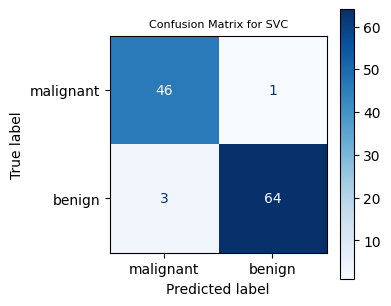

In [10]:
# insert your code here

_show_confusion_matrix(model=model,y_true=y_test,y_pred=y_pred,target_names=target_names)

<details><summary><span style="color:blue">&#x1F6C8; Hint</span></summary>

Find the Library of Helper Functions code at the top.
```Pytho

# _show_confusion_matrix( ... )
```

</details>

## Q5i: What is the metric score (as you identified above) according to the model's performance on the `test` set:
*(example:  F1 Score and 0.95)*
* Ans: F1 Score 0.9583

### Q5.ii: What is the model's `weighted avg F1-Score`?

Ans: 0.965

### Q5.iii: Are the model's `weighted avg Precision` and `weighted avg Recall` approximately equal?

Ans: It's closer to equal
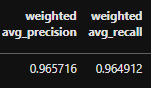

### Q5.iv: Do the `Majority` and `Minority` class(es) have approximately equal F1 Score?

Ans: yes

## Q6: Is the objective met?
- Considering we defined the **Minimum Metric Score is 0.9 or 90%.**
- Does the score from your model meet the objective to deliver this model as a service to a hospital?
 
* Ans: Yes

## Q7: Future Work: Make a note of two ideas to improve the model performance?
 
* Ans: Try new model
* Ans: drop some feture

```





















```

# Part 2 - Analysing the Iris Dataset.
Following the similar steps as Part 1, this time we have 3 classes instead of 2.

Fill in the code and answer the questions according to the steps below:

**Steps:**

- **Step 0:** 	Define the Dataset and Objective:
    - Consider Actions: 
        - `setosa` `versicolor` `virginica` -> No Action.
    - A good model can be used by walkers and trekkers to count flowers.
- **Step 1:** 	Identify which cell is most crucial.
    - Each class has equal importance.
- **Step 2:** 	Define Positive (P) and Negative (N)
    - In this case, the classes define themselves. i.e. TP becomes TP1, TP2, TP3 (for each class). Similarly with FP, FN, TN.
        - `setosa`
        - `versicolor`
        - `virginica`
- **Step 3:** 	State True and False
-  …fit model,  evaluate model ,  count errors …
- **Step 4:** 	Calculate the metric
- **Step 5:** 	Decide if objective met.
    - Consider **Minimum Metric Score is 0.9 or 90%.**
    - If above this level, it can be used by walkers and trekkers to count flowers.


Iris Dataset (Fisher, 1936):
- Dataset Source: https://archive.ics.uci.edu/dataset/53/iris

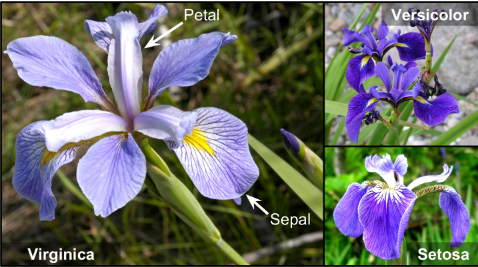

Image credit: Photos reproduced from the corresponding Wikipedia pages. Iris virginica photo by Frank Mayfield (Creative Commons BY-SA 2.0), Iris versicolor photo by D. Gordon E. Robertson (Creative Commons BY-SA 3.0), Iris setosa photo public domain.

## Q1: Identify which Class is most important:
* Ans:  Defined as `All Equal`.

## Q2: Identify which Error (FP or FN) is most important:

(Either (1) `FP and FN` or (2) `FP` or (3) `FN` is most important. Explain why in a sentence.)

* Ans: FP and FN, because we need to predict all correct

## Q3.i: Which Metric is helps measure that condition?

* Ans: avg weight f1 score 

### Load the dataset

In [11]:
from sklearn import datasets
import pandas as pd
import numpy as np
data = datasets.load_iris()
# print(data['DESCR'])

Class Split: [0.33333333 0.33333333 0.33333333]


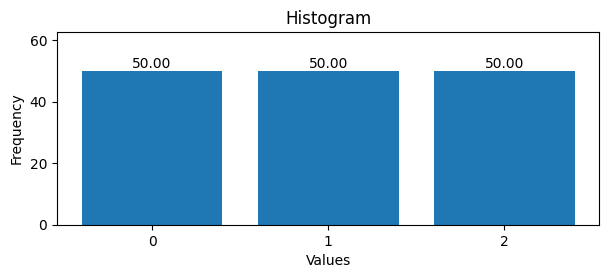

Target classes:  ['setosa' 'versicolor' 'virginica']


In [12]:
df = pd.DataFrame(data=np.c_[data['data'], data['target']],
                     columns=data['feature_names'] + ['target'])
_plot_histogram_of_frequencies(df['target'])
target_names = data['target_names']
print('Target classes: ', target_names)

## Q3.ii: See the Histogram showing class balance. According to the slides, which `two metrics` can we choose for to measure this dataset and with `equal` emphasis on `FP and FN`?

* Ans: equal

### Select `X` (input features) and `y` (target feature):
* Define your X and y data, from features in the `breast_cancer` dataset:

In [13]:
# insert your code here
display(df.head(1))

X = df.drop(columns="target")
y = df["target"]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0


### Split as X and y:
* Split X / y into train and test sets.

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=0)

### Choose a model to fit() on the training data:
* Model Options:
    1. Previously we have imported and fitted a `LogisticRegression()` model.
    2. Read and choose a model from [Scikit-Learn's Classifer Comparison page](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html).
 
If you choose a K Nearest Neigbour algorithm, be sure to use StandardScaler on the X_train / X_test data.

* Choose a `model = ... ()` and `model.fit( ... )` on the training data.

In [15]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression()

## Use K-Folds Cross Validation, k=5 using dataset shuffling and stratified by the target class
* K-Folds Cross Validation gives us robust information about how well the model fits the dataset.
* See the slides and Tutorial code as an example.
* Print the Mean and Standard deviation of the result.

In [16]:
# insert your code here
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score

kf = StratifiedShuffleSplit(n_splits=5)

train_f1_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='f1_weighted')
print(train_f1_scores)
print(f"mean = {np.mean(train_f1_scores):.5f}")
print(f"std = {np.std(train_f1_scores):.5f}")

[1.         0.91534392 1.         0.91534392 0.91534392]
mean = 0.94921
std = 0.04147


<details><summary><span style="color:red">&#x1F6C8; Help</span> (Use this only as a last resort!!)</summary>

```Python
kf = StratifiedShuffleSplit(n_splits=5)

train_f1_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='f1')
print(train_f1_scores)
# np.mean() , np.std()
```

</details>

### Evaluate on the Test Set:
*  Collect prediction results (`y_pred`) on test data (`X_test`)

* Print the Classification report.
*  Print the Confusion Matrix.

Accuracy: 0.9737
Sensitivity: 0.9737
Specificity: 0.9737
Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        13
  versicolor       1.00      0.94      0.97        16
   virginica       0.90      1.00      0.95         9

    accuracy                           0.97        38
   macro avg       0.97      0.98      0.97        38
weighted avg       0.98      0.97      0.97        38



c:\Users\gifly\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1618: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'weighted'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


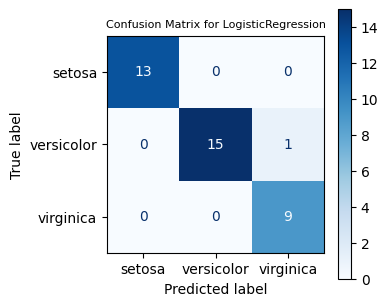

In [17]:
y_pred = model.predict(X_test)
_show_classification_report(model, y_test, y_pred, target_names)
_show_confusion_matrix(model, y_test, y_pred, target_names)

<details><summary><span style="color:blue">&#x1F6C8; Hint</span></summary>

```Python
... = model.predict(X_test)
# _show_classification_report( ... )
# _show_confusion_matrix( ... )
```

</details>

## Q5i: What is the metric score (identified above) according to the model's performance on the `test` set:

* Ans: 0.97

## Q5.ii: Are the model's `weighted avg Precision` and `weighted avg Recall` approximately equal?

Ans: ___Yes, it is__


## Q5.iii: Do each of the classes have approximately equal F1 Score?

Ans: ____Yes, it is___

## Q5.iv: How many `records` were predicted in `total for all classes` (*setosa, versicolor, virginica*)? 
*(see "Support" column or count in the matrix)*

Ans: ____38___

## Q6: Is the objective met?
- Considering we defined the **Minimum Metric Score is 0.9 or 90%.** for walkers and trekkers to count flowers.
- Does the score from your model meet the objective to deliver this model?
 
* Ans: __yes__

## Q7: Future Work: Make a note of `two ideas` to improve the model performance?
 
* Ans: Try new model
* Ans: find new feature

```












```
# Part 3 - Making Model Improvements (in Orange)

**Objective**
- The task here is to improve the `F1-Score` from **0.902-0.910**, so you are asked to make changes to improve the `F1-Score` to **0.965 or above**:.

> Note: It is possible to improve the F1 score to above 0.98 with this dataset within Orange.

## Task 1 - Tutorial Steps:
- Open the slides to the section with the **Guide to classify Cat & Dog images dataset in Orange**.
- Open **Orange Data Mining Tool**. (Download if necessary)
- Follow the guide to use the `LogisticRegression` model with `SqueezeNet` which should give an `F1-Score` of approximately **0.902-0.910** (average over all classes).

## Task 2 - Brainstorming Step:
* Think about the techniques you know about that might improve the model's F1 Score. 

### Q1: Make a note of about 3-5 `ideas` that might improve the model performance (don't start with them yet)

Answers: _______
* Try to change model parameter
* Try to train with multiple model
* Try to do data augmentation before train  


## Task 3 - Simplest First Step:
* Choosing the **simplest first** (Ocam's Razor!), try those approaches to improve the F1 Score, until you reach the target score and report back on which worked for you:

### Q2: Which techniques / steps led to improving the F1 Score to 0.965 or above on the `Train/Validation` data?

Ans: _Use neural network

### Q3: Include a Screenshot of your Orange Workspace and including its best F1-Score:

Ans: 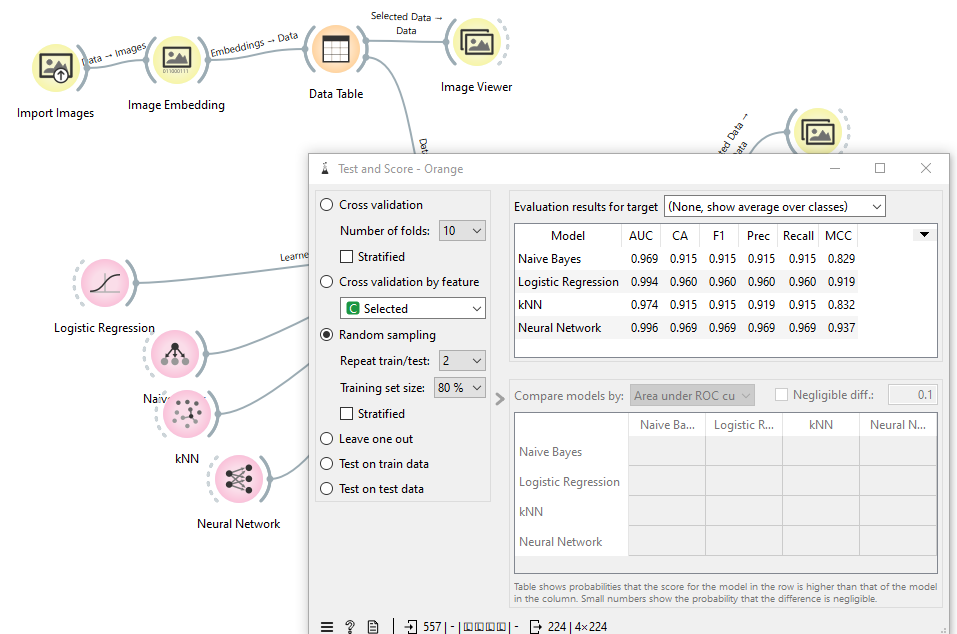

#### Next:
#### Step 1: Import the `Test dataset` (see image example below).
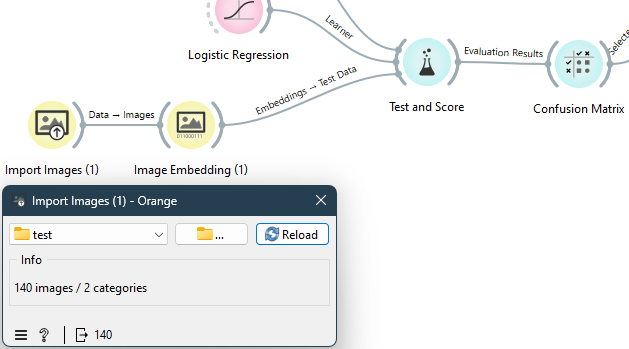
#### Step 2: Update the `Test & Score` Evaluation to `Test on test data`.

### Q4: Include a screenshot of your `F1-Score` on the `Test set` data:

Ans: ___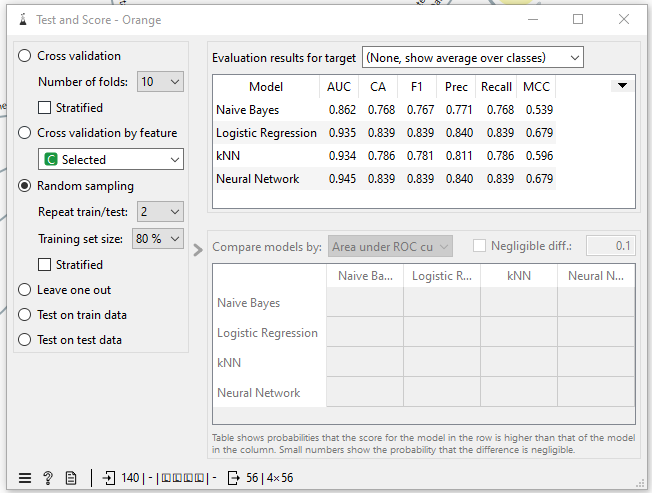__

```






```
<p style="text-align:center;">That's it! Congratulations! <br> 
    Now, call an LA to check your solution. Then, upload your code on MyCourses.</p>